## Mask R-CNN - Train on NewShapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import mrcnn.model_mrcnn  as mrcnn_modellib
import mrcnn.model_fcn    as fcn_modellib
import mrcnn.visualize    as visualize
import mrcnn.new_shapes   as shapes
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 
# from mrcnn.utils        import log, stack_tensors, stack_tensors_3d, write_stdout
from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
# from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.coco         import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
from mrcnn.prep_notebook import mrcnn_newshape_train, prep_newshape_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

####  Pass input parameters to argparse

# args = parser.parse_args("--epochs 100 --steps_in_epoch 128  --last_epoch 1264 --batch_size 8  --lr 0.5               --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model init".split())
# input_parms = "--epochs 100 --steps_in_epoch 100  --last_epoch 1264 --batch_size 25 --lr 0.8 --val_steps 5 --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
# input_parms +=" --model     /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 "
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = "--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 1 --lr 0.00001 --val_steps 8 " 
input_parms +="--mrcnn_logs_dir train_mrcnn_newshapes "
input_parms +="--fcn_logs_dir   train_fcn8_newshapes "
input_parms +="--mrcnn_model    last "
input_parms +="--fcn_model      init "
input_parms +="--opt            adagrad "
input_parms +="--fcn_arch       fcn8 " 
input_parms +="--fcn_layers     all " 
input_parms +="--sysout        screen "
input_parms +="--new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
print(input_parms)

args = parser.parse_args(input_parms.split())
# args = parser.parse_args()

##----------------------------------------------------------------------------------------------
## if debug is true set stdout destination to stringIO
##----------------------------------------------------------------------------------------------            
# debug = False
if args.sysout == 'FILE':
    sys.stdout = io.StringIO()

# print("    Dataset            : ", args.dataset)
# print("    Logs               : ", args.logs)
# print("    Limit              : ", args.limit)
print("    MRCNN Model        : ", args.mrcnn_model)
print("    FCN Model          : ", args.fcn_model)
print("    MRCNN Log Dir      : ", args.mrcnn_logs_dir)
print("    FCN Log Dir        : ", args.fcn_logs_dir)
print("    FCN Arch           : ", args.fcn_arch)
print("    FCN Log Dir        : ", args.fcn_layers)
print("    Last Epoch         : ", args.last_epoch)
print("    Epochs to run      : ", args.epochs)
print("    Steps in each epoch: ", args.steps_in_epoch)
print("    Validation steps   : ", args.val_steps)
print("    Batch Size         : ", args.batch_size)
print("    Optimizer          : ", args.opt)
print("    sysout             : ", args.sysout)
# print("    OS Platform        : ", syst)

##------------------------------------------------------------------------------------
## setup project directories
##   ROOT_DIR         : Root directory of the project 
##   MODEL_DIR        : Directory to save logs and trained model
##   COCO_MODEL_PATH  : Path to COCO trained weights
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = args.fcn_logs_dir, mrcnn_training_folder = args.mrcnn_logs_dir)
paths.display()

Using TensorFlow backend.



--> Execution started at: 11-04-2018 @ 16:40:51
    Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 1 --lr 0.00001 --val_steps 8 --mrcnn_logs_dir train_mrcnn_newshapes --fcn_logs_dir   train_fcn8_newshapes --mrcnn_model    last --fcn_model      init --opt            adagrad --fcn_arch       fcn8 --fcn_layers     all --sysout        screen --new_log_folder    
    MRCNN Model        :  last
    FCN Model          :  init
    MRCNN Log Dir      :  train_mrcnn_newshapes
    FCN Log Dir        :  train_fcn8_newshapes
    FCN Arch           :  FCN8
    FCN Log Dir        :  ['all']
    Last Epoch         :  0
    Epochs to run      :  2
    Steps in each epoch:  32
    Validation steps   :  8
    Batch Size         :  1
    Optimizer          :  ADAGRAD
    sysout             :  SCREEN
>>> Initialize Paths
 Linx  Linux

Paths:
-------------------------
COCO_DATASET_PATH              /home/kbardool/MLDatasets/coco2014
COCO_MODEL

### Build Configuration Object

In [2]:
##------------------------------------------------------------------------------------
## Build configuration object 
##------------------------------------------------------------------------------------                          
# mrcnn_config                    = CocoConfig()
import mrcnn.new_shapes as new_shapes
mrcnn_config = new_shapes.NewShapesConfig()

mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = int(args.batch_size)                  # Must match BATCH_SIZE

mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
mrcnn_config.LEARNING_RATE      = float(args.lr)
mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)

mrcnn_config.WEIGHT_DECAY       = 2.0e-4
mrcnn_config.VALIDATION_STEPS   = int(args.val_steps)
mrcnn_config.REDUCE_LR_FACTOR   = 0.5
mrcnn_config.REDUCE_LR_COOLDOWN = 30
mrcnn_config.REDUCE_LR_PATIENCE = 40
mrcnn_config.EARLY_STOP_PATIENCE= 80
mrcnn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
mrcnn_config.MIN_LR             = 1.0e-10
mrcnn_config.OPTIMIZER          = args.opt.upper()
mrcnn_config.NEW_LOG_FOLDER       = True
mrcnn_config.SYSOUT               = args.sysout
mrcnn_config.display() 



Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COCO_CLASSES                   None
COCO_DATASET_PATH              /home/kbardool/MLDatasets/coco2014
COCO_MODEL_PATH                /home/kbardool/PretrainedModels/mask_rcnn_coco.h5
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            80
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_BUFFER                   20
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                   

###  Build Model

In [3]:
from mrcnn.prep_notebook import mrcnn_newshape_train
mrcnn_model, mrcnn_config = mrcnn_newshape_train(mode = 'training', mrcnn_config = mrcnn_config)

>>> Initialize ModelBase model 
   Mode      :  training
   Model dir :  /home/kbardool/models/train_mrcnn_newshapes
>>> ModelBase initialiation complete
>>> ---Initialize MRCNN model, mode:  training
>>> set_log_dir(): model_path:  None
    set_log_dir(): model_path has NOT been provided : None 
                  NewFolder: False  config.NEW_LOG_FOLDER: True 
    set_log_dir(): weight file template (self.checkpoint_path): /home/kbardool/models/train_mrcnn_newshapes/mrcnn20181104T1640/mrcnn_{epoch:04d}.h5 
    set_log_dir(): weight file dir      (self.log_dir)        : /home/kbardool/models/train_mrcnn_newshapes/mrcnn20181104T1640 
    set_log_dir(): Last completed epoch (self.epoch)          : 0 

----------------------------
>>> Resnet Graph 
----------------------------
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 

     Prob_grid shape :  (?, 32, 32)
    prob_grid_clipped      :  (?, 32, 32)
    scores_scattered shape :  (1, 7, 32, 3)
    gauss_scores           :  (1, 7, 32, 11)  Name:    cntxt_layer_gt/gt_heatmap_scores:0
    gauss_scores  (FINAL)  :  (1, 7, 32, 11)  Keras tensor  False

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 32, 32)
    gauss_heatmap   :  (1, 7, 32, 32, 32)

    Reduce MAX based on class ---------------------------------------------
    gaussian_heatmap :  (1, 7, 32, 32) Keras tensor  False
    gauss_heatmap :  (1, 32, 32, 7)  Keras tensor  False

    gt_heatmap                  :  (1, 32, 32, 7) Keras tensor  False
    gt_heatmap_scores           :  (1, 7, 32, 11) Keras tensor  False
    complete
<<<  shape of pred_heatmap   :  (1, 32, 32, 7)  Keras tensor  True
<<<  shape of gt_heatmap     :  (1, 32, 32, 7)  Keras tensor  True


---------------------------------------------------
   

### Load saved weights

In [4]:
##------------------------------------------------------------------------------------
## Load Mask RCNN Model Weight file
##------------------------------------------------------------------------------------
# exclude_list = ["mrcnn_class_logits"]
#load_model(model, init_with = args.model)   
exclude_list = ["mrcnn_class_logits", "mrcnn_bbox_fc"]
mrcnn_model.load_model_weights(init_with = 'coco', exclude = exclude_list, verbose = True)   

-----------------------------------------------
 Load Model with init parm: [ coco ]
 Exclude layers: 
    -  mrcnn_class_logits
    -  mrcnn_bbox_fc
-----------------------------------------------
 ---> coco : /home/kbardool/PretrainedModels/mask_rcnn_coco.h5
>>> load_weights() from : /home/kbardool/PretrainedModels/mask_rcnn_coco.h5
layers type:  <class 'list'> length:  385
 Weight Matchup between model and HDF5 weights 

  0 input_image               Model Layer Name/Type : [['input_image', 'InputLayer']] 

  1 zero_padding2d_1          Model Layer Name/Type : [['zero_padding2d_1', 'ZeroPadding2D']] 

  2 conv1                     Model Layer Name/Type : [['conv1', 'Conv2D']] 
    0 conv1/kernel:0                       hdf5 Weights: (7, 7, 3, 64)  		 Symbolic Wghts: (7, 7, 3, 64)   
    1 conv1/bias:0                         hdf5 Weights: (64,)  		 Symbolic Wghts: (64,)   

  3 bn_conv1                  Model Layer Name/Type : [['bn_conv1', 'BatchNorm']] 
    0 bn_conv1/gamma:0     

    2 bn4j_branch2b/moving_mean:0          hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   
    3 bn4j_branch2b/moving_variance:0      hdf5 Weights: (256,)  		 Symbolic Wghts: (256,)   

177 activation_35             Model Layer Name/Type : [['activation_35', 'Activation']] 

178 res4j_branch2c            Model Layer Name/Type : [['res4j_branch2c', 'Conv2D']] 
    0 res4j_branch2c/kernel:0              hdf5 Weights: (1, 1, 256, 1024)  		 Symbolic Wghts: (1, 1, 256, 1024)   
    1 res4j_branch2c/bias:0                hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   

179 bn4j_branch2c             Model Layer Name/Type : [['bn4j_branch2c', 'BatchNorm']] 
    0 bn4j_branch2c/gamma:0                hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    1 bn4j_branch2c/beta:0                 hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    2 bn4j_branch2c/moving_mean:0          hdf5 Weights: (1024,)  		 Symbolic Wghts: (1024,)   
    3 bn4j_branch2c/moving_variance:0      hdf


337 res5c_branch2b            Model Layer Name/Type : [['res5c_branch2b', 'Conv2D']] 
    0 res5c_branch2b/kernel:0              hdf5 Weights: (3, 3, 512, 512)  		 Symbolic Wghts: (3, 3, 512, 512)   
    1 res5c_branch2b/bias:0                hdf5 Weights: (512,)  		 Symbolic Wghts: (512,)   

338 bn5c_branch2b             Model Layer Name/Type : [['bn5c_branch2b', 'BatchNorm']] 
    0 bn5c_branch2b/gamma:0                hdf5 Weights: (512,)  		 Symbolic Wghts: (512,)   
    1 bn5c_branch2b/beta:0                 hdf5 Weights: (512,)  		 Symbolic Wghts: (512,)   
    2 bn5c_branch2b/moving_mean:0          hdf5 Weights: (512,)  		 Symbolic Wghts: (512,)   
    3 bn5c_branch2b/moving_variance:0      hdf5 Weights: (512,)  		 Symbolic Wghts: (512,)   

339 activation_67             Model Layer Name/Type : [['activation_67', 'Activation']] 

340 res5c_branch2c            Model Layer Name/Type : [['res5c_branch2c', 'Conv2D']] 
    0 res5c_branch2c/kernel:0              hdf5 Weights: (1, 1,

   Weights file loaded: /home/kbardool/PretrainedModels/mask_rcnn_coco.h5 
MRCNN  MODEL Load weight file COMPLETE 


### Build newshape datasets

In [5]:
# del dataset_train, dataset_val, train_generator, val_generator
from mrcnn.prep_notebook import prep_newshape_dataset
dataset_train, train_generator = prep_newshape_dataset( mrcnn_config, 10000, generator=True)
dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_config,  2500, generator=True)

In [6]:
print(type(dataset_train), type(train_generator))
print(len(dataset_train.image_info))
print(type(dataset_val), type(val_generator))
print(len(dataset_val.image_info))

<class 'mrcnn.new_shapes.NewShapesDataset'> <class 'generator'>
10000
<class 'mrcnn.new_shapes.NewShapesDataset'> <class 'generator'>
2500


### Load Training Files and Display Images

####  Display next image from generator

In [7]:
train_batch_x, train_batch_y = next(train_generator)

Image id:  6037
Image meta [6037  128  128    3    0    0  128  128    1    1    1    1    1    1    1]


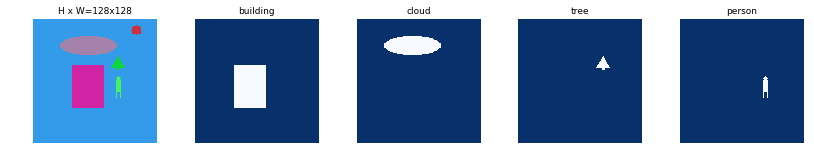

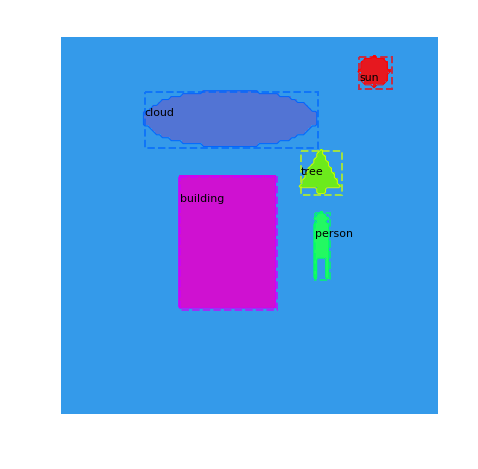

In [8]:


class_names = dataset_train.class_names
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
#     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))  

#### Load a specific image using image_id

In [ ]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 89243: Person, bicylce and traiffic lights
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
## 33477 Table, bowl, cup, sandwich, knife
# train_batch_x, train_batch_y = next(train_generator)
# IMAGE_LIST = [75040] 
# IMAGE_LIST = [89243]
IMAGE_LIST = [2000,4000,5000,6000]
# IMAGE_LIST = [29731]
train_batch_x, train_batch_y = test_batch_x, test_batch_y = data_gen_simulate(dataset_train, mrcnn_config, IMAGE_LIST)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(len(IMAGE_LIST)):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
    print(' Dataset coco file:', dataset_train.image_info[image_id]['id'])
    print(' Image meta  : ', img_meta[img_idx,:10])
    print(' Classes     : ', class_ids)
    print(" Image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
    print(' Class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0])       
    print(' Class Names : ', class_names)
    
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
    # Display image and instances
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)

###  Print some model information 

In [ ]:
mrcnn_model.layer_info()

### Train mrcnn model : `train()`

In [9]:
# mrcnn_model.config.EPOCHS_TO_RUN = 1
# mrcnn_model.config.STEPS_PER_EPOCH = 2
# mrcnn_model.config.SYSOUT = 'screen'
 
print('    last epoch ran : ',mrcnn_model.config.LAST_EPOCH_RAN)
print('    epochs to run  : ',mrcnn_model.config.EPOCHS_TO_RUN)
print('    steps per epoch: ',mrcnn_model.config.STEPS_PER_EPOCH)
print('    learning rate  : ', mrcnn_model.config.LEARNING_RATE)
print('    momentum       : ', mrcnn_model.config.LEARNING_MOMENTUM)
print('    weight decay   : ',mrcnn_model.config.WEIGHT_DECAY)


    last epoch ran :  0
    epochs to run  :  2
    steps per epoch:  32
    learning rate  :  1e-05
    momentum       :  0.9
    weight decay   :  0.0002


### Training mrcnn, fpn, rpn layers

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
# Wed 09-05-2018
# config.STEPS_PER_EPOCH        = 8
# config.EARLY_STOP_PATIENCE    = 70
train_layers = [ 'mrcnn', 'fpn','rpn']
loss_names   = [ "rpn_class_loss", "rpn_bbox_loss" , "mrcnn_class_loss", "mrcnn_bbox_loss"]
# train_layers = [ 'mrcnn']
# loss_names   = [ "mrcnn_class_loss", "mrcnn_bbox_loss"]

mrcnn_model.epoch = mrcnn_model.config.LAST_EPOCH_RAN

mrcnn_model.train(dataset_train, 
            dataset_val, 
            learning_rate = mrcnn_model.config.LEARNING_RATE, 
            epochs_to_run = mrcnn_model.config.EPOCHS_TO_RUN,
            layers = train_layers,
            losses = loss_names
#             epochs = 25,            # total number of epochs to run (accross multiple trainings)
#             batch_size = 0
#             steps_per_epoch = 0 
            )


['mrcnn', 'fpn', 'rpn']
['(mrcnn\\_.*)', '(fpn\\_.*)', '(rpn\\_.*)']
layers regex : (mrcnn\_.*)|(fpn\_.*)|(rpn\_.*)
type train_dataset: <class 'mrcnn.new_shapes.NewShapesDataset'>
type val_dataset: <class 'mrcnn.new_shapes.NewShapesDataset'>
    learning rate :  1e-05
    momentum      :  0.9


Selecting layers to train
-------------------------
Layer    Layer Name               Layer Type
   0  input_image            (InputLayer          )   ............................no weights to train ]
   1  zero_padding2d_1       (ZeroPadding2D       )   ............................no weights to train ]
   2  conv1                  (Conv2D              )   ............................not a layer we want to train ]
   3  bn_conv1               (BatchNorm           )   ............................not a layer we want to train ]
   4  activation_1           (Activation          )   ............................no weights to train ]
   5  max_pooling2d_1        (MaxPooling2D        )   ...............


L2 Regularization losses:
-------------------------
   Tensor("truediv:0", shape=(), dtype=float32)    name: truediv:0
   Tensor("truediv_1:0", shape=(), dtype=float32)    name: truediv_1:0
   Tensor("truediv_2:0", shape=(), dtype=float32)    name: truediv_2:0
   Tensor("truediv_3:0", shape=(), dtype=float32)    name: truediv_3:0
   Tensor("truediv_4:0", shape=(), dtype=float32)    name: truediv_4:0
   Tensor("truediv_5:0", shape=(), dtype=float32)    name: truediv_5:0
   Tensor("truediv_6:0", shape=(), dtype=float32)    name: truediv_6:0
   Tensor("truediv_7:0", shape=(), dtype=float32)    name: truediv_7:0
   Tensor("truediv_8:0", shape=(), dtype=float32)    name: truediv_8:0
   Tensor("truediv_9:0", shape=(), dtype=float32)    name: truediv_9:0
   Tensor("truediv_10:0", shape=(), dtype=float32)    name: truediv_10:0
   Tensor("truediv_11:0", shape=(), dtype=float32)    name: truediv_11:0
   Tensor("truediv_12:0", shape=(), dtype=float32)    name: truediv_12:0
   Tensor("truediv_13:

/home/kbardool/anaconda3/envs/TFG/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
32/32 [==============================] - 15s 471ms/step - loss: 3.8507 - rpn_class_loss: 0.1947 - rpn_bbox_loss: 1.4301 - mrcnn_class_loss: 1.2636 - mrcnn_bbox_loss: 0.9624 - val_loss: 3.9422 - val_rpn_class_loss: 0.1747 - val_rpn_bbox_loss: 1.4817 - val_mrcnn_class_loss: 1.1635 - val_mrcnn_bbox_loss: 1.1224

Epoch 00001: val_loss improved from inf to 3.9422112, saving model to /home/kbardool/models/train_mrcnn_newshapes/mrcnn20181104T1640/mrcnn_0001.h5
Epoch 2/2
32/32 [==============================] - 5s 164ms/step - loss: 3.2722 - rpn_class_loss: 0.1739 - rpn_bbox_loss: 1.3969 - mrcnn_class_loss: 0.6857 - mrcnn_bbox_loss: 1.0157 - val_loss: 3.1498 - val_rpn_class_loss: 0.1690 - val_rpn_bbox_loss: 1.3900 - val_mrcnn_class_loss: 0.5195 - val_mrcnn_bbox_loss: 1.0712

Epoch 00002: val_loss improved from 3.9422112 to 3.1498065, saving model to /home/kbardool/models/train_mrcnn_newshapes/mrcnn20181104T1640/mrcnn_0002.h5
Final : self.epoch 2   epochs 2


### Training - FCN

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

    - #### Or now we can pass a list of layers we want to train in layers !
2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

### Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_2500.h5")
model.keras_model.save_weights(model_path)

## Push Data thru model using get_layer_output()

In [ ]:

layers_out = get_layer_output_2(model.keras_model, train_batch_x, 1)


In [ ]:
input_gt_class_ids = train_batch_x[4]

target_class_ids = layers_out[5]
mrcnn_class_logits = layers_out[9]
rpn_class_loss   = layers_out[13]
rpn_bbox_loss    = layers_out[14]
mrcnn_class_loss = layers_out[15]
mrcnn_bbox_loss  = layers_out[16]
mrcnn_mask_loss  = layers_out[17]
active_class_ids = layers_out[20]
# pred_masks = tf.identity(layers_out[18])
# gt_masks   = tf.identity(layers_out[19])

# shape = KB.int_shape(pred_masks)

In [ ]:
print(rpn_class_loss, rpn_bbox_loss)
print(mrcnn_class_loss, mrcnn_bbox_loss, mrcnn_mask_loss)
print(active_class_ids)
print()
print(target_class_ids[1])
print()
print(mrcnn_class_logits[1])
print('gt class ids')
print(input_gt_class_ids)

## Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer


### Plot Output from FCN network `fcn_bilinear` and compare with `pred_gaussian`

### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox[0:3,:])
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox[0:3])

# image_id = img_meta[img,0]
# print('Image id: ',image_id)
# p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
#             load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# # print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
# print(p_gt_bbox)
# print(p_gt_class_id)
# visualize.draw_boxes(p_original_image, p_gt_bbox)

### Display Predicted  Ground Truth Bounding Boxes  `gt_tensor` and `gt_tensor2`

layers_out[22]  `gt_tensor` is based on input_gt_class_ids and input_normlzd_gt_boxes
layers_out[28]  `gt_tensor2` is based on input_gt_class_ids and input_normlzd_gt_boxes, generated using Tensorflow

Display the Ground Truth bounding boxes from the tensor we've constructed

In [ ]:
from mrcnn.utils  import stack_tensors, stack_tensors_3d
# print(gt_bboxes)
# visualize.display_instances(p_original_image, p_gt_bbox, p_gt_mask, p_gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))
# pp.pprint(gt_bboxes)
img = 0
image_id = img_meta[img,0]

print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)   
gt_bboxes_stacked = stack_tensors_3d(layers_out[22][img])
print(gt_bboxes_stacked)
visualize.draw_boxes(p_image, gt_bboxes_stacked[0:2,2:6])


## Display RoI proposals `pred_bboxes` generated for one class

Display bounding boxes from tensor of proposals produced by the network 
Square: 1 , Circle:2 , Triangle 3

In [ ]:
img = 0
cls = 1 # <==== Class to display
pred_tensor = layers_out[19]   # numpy pred_tesnor
# pred_tensor = layers_out[25]   # tensorflow pred_tensor 

image_id = img_meta[img,0]
print('Image id: ',image_id)
p_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
print(p_image_meta)dd
print(pred_tensor[img,cls,:].shape)
print(pred_tensor[img,cls])
#+'-'+str(np.around(int(x[1]),decimals = 3))
# class id: str(int(x[6]))+'-'+
caps = [str(int(x[0]))+'-'+str(np.around(x[1],decimals = 3))  for x in pred_tensor[img,cls,:].tolist() ]
print(caps)

visualize.draw_boxes(p_image, pred_tensor[img,cls,:,2:6], captions = caps)

In [ ]:
layers_out[0][0] * [128, 128,128,128]   #output_rois*

### Calculate  mrcnn_bbox_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
target_bbox      = layers_out[2][0:1]
mrcnn_bbox       = layers_out[10][0:1]
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print('target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class with max probability', mrcnn_class_ids.shape)
print(mrcnn_class_ids)
print('target_bboxes', target_bbox.shape)
# print(target_bbox)  # tgt_bounding boxes
print('mrcnn_bboxes',mrcnn_bbox.shape)
# print(mrcnn_bbox)  #mrcnn_bboxes
pred_bbox = mrcnn_bbox

# calc mrcnn_bbox_loss
target_class_ids = K.reshape(target_class_ids, (-1,))
print(target_class_ids.shape)
target_bbox      = K.reshape(target_bbox, (-1, 4))
print('target_bboxx: ', target_bbox.shape)
pred_bbox        = K.reshape(pred_bbox, (-1, pred_bbox.shape[2], 4))
print('pred_bbox : ', pred_bbox.shape)

positive_roi_ix        = tf.where(target_class_ids > 0)[:, 0]
print(positive_roi_ix.eval())
positive_roi_class_ids = tf.cast( tf.gather(target_class_ids, positive_roi_ix), tf.int64)
print(positive_roi_class_ids.eval())
indices                = tf.stack([positive_roi_ix, positive_roi_class_ids], axis=1)
print(indices.eval())


target_bbox = tf.gather(target_bbox, positive_roi_ix)
print(target_bbox.eval())
pred_bbox   = tf.gather_nd(pred_bbox, indices)
print(pred_bbox.eval())

print('tf.size ',tf.size(target_bbox).eval())

diff = K.abs(target_bbox - pred_bbox)
print(diff.eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(less_than_one.eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print( (1-less_than_one).eval())



# loss        = K.switch(tf.size(target_bbox) > 0,
#                 smooth_l1_loss(y_true=target_bbox, y_pred=pred_bbox),
#                 tf.constant(0.0))
print(loss.eval())
sumloss = K.sum(loss)
print(sumloss.eval())
print((sumloss/40).eval())
meanloss        = K.mean(loss)
print(meanloss.eval())

###  Calculate mrcnn_class_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids = layers_out[1][0:1]
pred_class_logits = layers_out[8][0:1]
active_class_ids    = np.array([1,1,1,1])

# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids

print(' target_class_ids', target_class_ids.shape)
print(target_class_ids)  # tgt_class_ids
print(' class logits', pred_class_logits.shape)
print(pred_class_logits)
print(' active, class_ids ', active_class_ids.shape)
print(active_class_ids)  # tgt_bounding boxes

pred_class_ids = tf.argmax(pred_class_logits, axis=2)
print(pred_class_ids.eval())  #mrcnn_bboxes
mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print(mrcnn_class_ids)
# pred_bbox = mrcnn_bbox
pred_active = tf.to_float(tf.gather(active_class_ids, pred_class_ids))
print(pred_active.eval())
# calc mrcnn_bbox_loss
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
       labels=target_class_ids, logits=pred_class_logits)
print(loss.eval())

loss = loss * tf.to_float(pred_active)
print(loss.eval())

print(tf.reduce_sum(loss).eval())
print(tf.reduce_sum(pred_active).eval())
loss = tf.reduce_sum(loss) / tf.reduce_sum(pred_active)
print(loss.eval())

###  Calculate mrcnn_mask_loss

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss

target_class_ids    = layers_out[1][0:3]
target_masks        = layers_out[3][0:3]
pred_masks          = layers_out[11][0:3]
# mrcnn_class_ids  = np.argmax(layers_out[9][0:1],axis = -1)     # mrcnn_class_ids
print('    target_class_ids shape :', target_class_ids.shape)
print('    target_masks     shape :', target_masks.shape)
print('    pred_masks       shape :', pred_masks.shape)    


target_class_ids = K.reshape(target_class_ids, (-1,))
print('    target_class_ids shape :', target_class_ids.shape, '\n', target_class_ids.eval())

mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', mask_shape.shape, mask_shape.eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[2], mask_shape[3]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', pred_shape.shape, pred_shape.eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[2], pred_shape[3], pred_shape[4]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        


pred_masks = tf.transpose(pred_masks, [0, 3, 1, 2])
print('    pred_masks       shape :', tf.shape(pred_masks).eval())        

# Only positive ROIs contribute to the loss. And only
# the class specific mask of each ROI.
positive_ix        = tf.where(target_class_ids > 0)[:, 0]
positive_class_ids = tf.cast(tf.gather(target_class_ids, positive_ix), tf.int64)
indices            = tf.stack([positive_ix, positive_class_ids], axis=1)
print(indices.eval())



y_true = tf.gather(target_masks, positive_ix)
print('     y_true shape:', tf.shape(y_true).eval())
y_pred = tf.gather_nd(pred_masks, indices)
print('     y_pred shape:', tf.shape(y_pred).eval())

loss = K.switch(tf.size(y_true) > 0,
                K.binary_crossentropy(target=y_true, output=y_pred),
                tf.constant(0.0))
print(tf.shape(loss).eval())

loss = K.mean(loss)
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', tf.shape(loss).eval())
print(loss.eval())

### Calculate a pixel loss on fcn_gaussian and gt_gaussian 

In [ ]:
import keras.backend as K

from mrcnn.utils import apply_box_deltas
from mrcnn.loss  import smooth_l1_loss
pred_masks          = layers_out[12][0:3]
target_masks        = layers_out[27][0:3]

print('    target_masks     shape :', tf.shape(target_masks).eval())
print('    pred_masks       shape :', tf.shape(pred_masks).eval())    

diff = K.abs(target_masks - pred_masks)
print(tf.shape(diff).eval())

less_than_one = K.cast(K.less(diff, 1.0), "float32")
print(tf.shape(less_than_one).eval())

loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
print(tf.shape(loss).eval())

# print( (1-less_than_one).eval())

# loss = K.switch(tf.size(y_true) > 0,
#                 K.binary_crossentropy(target=y_true, output=y_pred),
#                 tf.constant(0.0))
meanloss = K.mean(loss)
print(tf.shape(meanloss).eval())
print(meanloss.eval())
# loss = K.reshape(loss, [1, 1])
# print('     final loss shape:', loss.get_shape())
# return loss


mask_shape       = tf.shape(target_masks)
print('    mask_shape       shape :', tf.shape(mask_shape).eval())    

target_masks     = K.reshape(target_masks, (-1, mask_shape[1], mask_shape[2]))
print('    target_masks     shape :', tf.shape(target_masks).eval())        

pred_shape       = tf.shape(pred_masks)
print('    pred_shape       shape :', tf.shape(pred_shape).eval())        

pred_masks       = K.reshape(pred_masks, (-1, pred_shape[1], pred_shape[2]))
print('    pred_masks       shape :', tf.shape(pred_masks).eval())
# Permute predicted masks to [N, num_classes, height, width]
# diff = K.abs(target_masks - pred_masks)
# print(tf.shape(diff).eval())

# less_than_one = K.cast(K.less(diff, 1.0), "float32")
# print(tf.shape(less_than_one).eval())

# loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
# print(tf.shape(loss).eval())

# meanloss = K.mean(loss)
# print(tf.shape(meanloss).eval())
# print(meanloss.eval())

loss = K.switch(tf.size(target_masks) > 0,
                smooth_l1_loss(y_true=target_masks, y_pred=pred_masks),
                tf.constant(0.0))
loss = K.mean(loss)
loss = K.reshape(loss, [1, 1])
print('     final loss shape:', loss.get_shape())
print(loss.eval())

###  Mean values of GT, Pred, and FCN heatmaps 

In [ ]:
pred_masks = tf.identity(layers_out[24])
gt_masks = tf.identity(layers_out[27])
fcn_masks = tf.identity(layers_out[12])
print(gt_masks.shape, fcn_masks.shape)
for img in range(5):
    for cls in range(4):
        gt_mean = K.mean(gt_masks[img,:,:,cls])
        fcn_mean= K.mean(fcn_masks[img,:,:,cls])
        pred_mean= K.mean(pred_masks[img,:,:,cls])
        print('Img/Cls: ', img, '/', cls,'    gtmean: ', gt_mean.eval(), '\t fcn : ' , fcn_mean.eval(), '\t pred :', pred_mean.eval())

In [ ]:
img  = 0
class_probs = layers_out[9][img]   # mrcnn_class
deltas      = layers_out[10][img]       # mrcnn_bbox

print(class_probs.shape)
print('class probabilities')
print(class_probs)
class_ids = np.argmax(layers_out[9][img],axis = 1)     # mrcnn_class_ids
print(' class with max probability')
print(class_ids)


# layers_out[10][2,0,3]
print('deltas.shape :', deltas.shape)
print(deltas[0:4])

deltas_specific = deltas[np.arange(32),class_ids]
print('deltas of max prob class: ', deltas_specific.shape)
print(deltas_specific[0:5])
output_rois = layers_out[0][img]*[128,128,128,128]
print('output_rois: ', output_rois.shape)
print(output_rois[0:])

refined_rois    = apply_box_deltas(output_rois, deltas_specific * config.BBOX_STD_DEV)
print('refined rois: ',refined_rois.shape)
print(refined_rois)